In [4]:
import random
import numpy as np

In [1]:
class BitSet:
  def __init__(self, size):
    self.bits = np.full((1, size), 0)
  
  def get(self, index):
    return self.bits[0, index]

  def set(self, index, value):
    self.bits[0, index] = value

  def flip(self, index):
    self.bits[0, index] = not self.bits[0, index]

  def debug(self):
    print(self.bits)

In [5]:
b = BitSet(5)
b.debug()

[[0 0 0 0 0]]


## Chromossome

In [6]:
class Chromossome:
  def __init__(self):
    x = random.randint(-15, 15) # Fenótipo Base10
    y = random.randint(-15, 15) # Fenótipo Base10
    
    self.__genes = Chromossome.get_genotype(x, y)
  
  @staticmethod
  def get_genotype(x, y):
    bits = BitSet(10)

    xy_binary = f"{x:>05b}{y:>05b}"

    for i in range(10):
      bits.set(i, xy_binary[i] == '1')
    
    return bits

  @staticmethod
  def get_fenotype(genes):
    # XXXXX YYYYY ( genótipo )
    # 01234 56789 ( índices )
    # 8421S 8421S ( S == 0 -> positivo, S == 1 -> negativo)
    # 00101 = -2
    # 10001 = -8

    x = (8 * genes.get(0) +
         4 * genes.get(1) +
         2 * genes.get(2) +
         1 * genes.get(3))
    
    if genes.get(4) == 1:
      x *= -1

    y = (8 * genes.get(5) +
         4 * genes.get(6) +
         2 * genes.get(7) +
         1 * genes.get(8))
    
    if genes.get(9) == 1:
      y *= -1

    return x, y

  def get_genes(self):
    return self.__genes

  def set_genes(self, genes):
    self.__genes = genes

  def to_string(self):
    chr_str = "G = ["
    for i in range(10):
      chr_str += (i == 5 and " " or "") + str(self.__genes.get(i))

    x, y = Chromossome.get_fenotype(self.__genes)
    chr_str += f"], F = [{x}, {y}]"

    return chr_str

In [7]:
c = Chromossome()

In [8]:
c.to_string()

'G = [00100 00011], F = [2, -1]'

## Problem

In [9]:
class Problem:
  @staticmethod
  def f(x, y):
    return x**2 + y**2

  @staticmethod
  def g(x, y):
    return 1 / (1 + Problem.f(x, y))

  @staticmethod
  def f_chromossome(chromossome):
    genes = chromossome.get_genes()
    x, y = Chromossome.get_fenotype(genes)
    return Problem.f(x, y)

  @staticmethod
  def g_chromossome(chromossome):
    genes = chromossome.get_genes()
    x, y = Chromossome.get_fenotype(genes)
    return Problem.g(x, y)

  @staticmethod
  def f_average(population):
    sum = 0
    for i in population:
      sum += Problem.f_chromossome(i)
    return sum / len(population)

  @staticmethod
  def g_average(population):
    sum = 0
    for i in population:
      sum += Problem.g_chromossome(i)
    return sum / len(population)

## Genetic Utils

In [10]:
class GeneticUtils:
  @staticmethod
  def find_best_chromossome(population):
    best_chromossome = None
    
    for c in population:
      score = Problem.g_chromossome(c)

      if best_chromossome is None or score > Problem.g_chromossome(best_chromossome):
        best_chromossome = c

    return best_chromossome

  @staticmethod
  def find_worst_chromossome(population):
    worst_chromossome = None
    
    for c in population:
      score = Problem.g_chromossome(c)

      if worst_chromossome is None or score < Problem.g_chromossome(worst_chromossome):
        worst_chromossome = c

    return worst_chromossome

  @staticmethod
  def format_chromossome(chromossome):
    return f"{chromossome.to_string()}, Score = {Problem.g_chromossome(chromossome):.3f}"

In [11]:
p = [Chromossome() for _ in range(5)]

In [12]:
print("\n".join([c.to_string() for c in p]))

G = [00100 01000], F = [2, 4]
G = [01010 01000], F = [5, 4]
G = [00101 00011], F = [-2, -1]
G = [00010 00110], F = [1, 3]
G = [00111 00110], F = [-3, 3]


In [13]:
w = GeneticUtils.find_worst_chromossome(p)
b = GeneticUtils.find_best_chromossome(p)

In [14]:
print(GeneticUtils.format_chromossome(w))
print(GeneticUtils.format_chromossome(b))

G = [01010 01000], F = [5, 4], Score = 0.024
G = [00101 00011], F = [-2, -1], Score = 0.167


## Genetic Operations

In [15]:
class GeneticOperators:
  MUTATION_PROBABILITY = 0.05 # 5%

  @staticmethod
  def selection(population):
    parent1 = random.choice(population)
    parent2 = random.choice(population)

    while parent1 is parent2:
      parent1 = random.choice(population)
      parent2 = random.choice(population)

    print(f"1st parent chosen for crossover: {GeneticUtils.format_chromossome(parent1)}")
    print(f"2st parent chosen for crossover: {GeneticUtils.format_chromossome(parent2)}")

    return parent1, parent2

  @staticmethod
  def crossover(population, parent1, parent2):
    crossover_point = random.randint(1, 9)
    print(f"Crossover will happen at point {crossover_point}")

    parent1_genes = parent1.get_genes()
    parent2_genes = parent2.get_genes()

    child1_genes = BitSet(10)
    child2_genes = BitSet(10)

    for i in range(0, crossover_point):
      child1_genes.set(i, parent1_genes.get(i))
      child2_genes.set(i, parent2_genes.get(i))

    for i in range(crossover_point, 10):
      child1_genes.set(i, parent2_genes.get(i))
      child2_genes.set(i, parent1_genes.get(i))

    child1 = Chromossome()
    child2 = Chromossome()

    child1.set_genes(child1_genes)
    child2.set_genes(child2_genes)

    print(f"1st child generated from crossover: {GeneticUtils.format_chromossome(child1)}")
    print(f"2st child generated from crossover: {GeneticUtils.format_chromossome(child2)}")

    population.append(child1)
    population.append(child2)

  @staticmethod
  def elitism(population):
    for _ in range(2):
      worst_individual = GeneticUtils.find_worst_chromossome(population)
      population.remove(worst_individual)
      print(f"Removing worst individual from population: {GeneticUtils.format_chromossome(worst_individual)}")

  @staticmethod
  def mutation(population):
    prob = random.uniform(0, 1)
    if prob >= GeneticOperators.MUTATION_PROBABILITY:
      return # não fazer a mutação

    target = random.choice(population)
    mutation_point = random.randint(0, 9)

    print(f"Individual {target.to_string()} will mutate at point {mutation_point}")

    genes = target.get_genes()
    genes.flip(mutation_point)

## Main

1st parent chosen for crossover: G = [01111 01101], F = [-7, -6], Score = 0.012
2st parent chosen for crossover: G = [00001 01110], F = [0, 7], Score = 0.020
Crossover will happen at point 9
1st child generated from crossover: G = [01111 01100], F = [-7, 6], Score = 0.012
2st child generated from crossover: G = [00001 01111], F = [0, -7], Score = 0.020
Removing worst individual from population: G = [01111 01101], F = [-7, -6], Score = 0.012
Removing worst individual from population: G = [01111 01100], F = [-7, 6], Score = 0.012
Generation #1 -> Average population score = 0.047


1st parent chosen for crossover: G = [00001 01111], F = [0, -7], Score = 0.020
2st parent chosen for crossover: G = [01000 00001], F = [4, 0], Score = 0.059
Crossover will happen at point 8
1st child generated from crossover: G = [00001 01101], F = [0, -6], Score = 0.027
2st child generated from crossover: G = [01000 00011], F = [4, -1], Score = 0.056
Removing worst individual from population: G = [01110 00101]

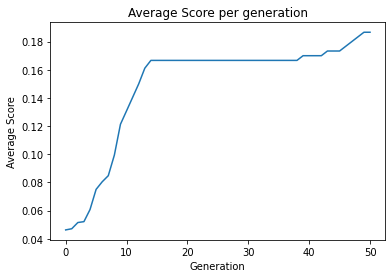

In [22]:
import matplotlib.pyplot as plt

if __name__ == "__main__":

  # Start population
  population = []

  for _ in range(10):
    population.append(Chromossome())

  generation = 0
  population_score = Problem.g_average(population)

  # Auxiliary variables for the plot
  generation_plot = [generation]
  population_score_plot = [population_score]

  # Performing iterations
  while generation < 50:
    parent1, parent2 = GeneticOperators.selection(population)

    GeneticOperators.crossover(population, parent1, parent2)
    GeneticOperators.mutation(population)
    GeneticOperators.elitism(population)

    generation += 1

    population_score = Problem.g_average(population)

    generation_plot.append(generation)
    population_score_plot.append(population_score)

    print(f"Generation #{generation} -> Average population score = {population_score:.3f}\n\n")

  best_chromossome = GeneticUtils.find_best_chromossome(population)
  print(f"Best individual: {GeneticUtils.format_chromossome(best_chromossome)}")

  plt.gca().set_xlabel("Generation")
  plt.gca().set_ylabel("Average Score")
  plt.gca().set_title("Average Score per generation")
  plt.plot(generation_plot, population_score_plot)
  plt.show()
